In [3]:
import pandas as pd
import numpy as np


url = 'Casos covid por provincias.xlsx'
df = pd.read_excel(url)
df = df.replace(np.nan, 0)
df=df[df['Provincia']=="Azuay"]
filtro = df.iloc[0].loc['19/3/2020':]
media = filtro.mean()*3
print(media)

345.8571428571429


In [5]:
import simpy
import random
import matplotlib.pyplot as pp
import numpy as np

%matplotlib inline

#PARAMETROS
HOSPITALES = 3
CAMAS = 563
RESPIRADORES=5
UCI=8
PERSONAL=278

COSTOB=3500
PRECIO_BAJO=int(COSTOB/15) 

PRECIOA=6700
PRECIOAIDA=int(PRECIOA/21)


INFECTADOS= 671
TASA_CRECIMIENTO = 48
DIAS_INTERNADO = 10
DIAS_SIMULACION = 25

costoTotal=[]
personalTotal={}
camasTotal={}
respiradoresTotal={}
UCITotal={}
ninios={}
adultos={}
atendidos={}
riesgo={}


persona_recuperadas={}
persona_fallecidas={}



class Hospital(object):

    def __init__(self, env,num_cama,name,num_personal,num_uci, num_respiradores):
            self.env = env
            self.num_cama = num_cama
            self.num_personal = num_personal
            self.num_uci=num_uci
            self.num_respiradores=num_respiradores
            self.camas = simpy.Resource(env, num_cama)
            self.personal = simpy.Resource(env, num_personal)
            self.uci = simpy.Resource(env, num_uci)
            self.respiradores = simpy.Resource(env, num_respiradores)
            self.name = name
        
    def ingreso_hospital(self, paciente):
        yield self.env.timeout(random.randint(DIAS_INTERNADO-5, DIAS_INTERNADO+5))
        print("Paciente Nº", paciente, "se le de de alta en el dia ", int(self.env.now))
        
    
        
    def cuidado_intensivo(self, paciente):
        yield self.env.timeout(random.randint(DIAS_INTERNADO-3, DIAS_INTERNADO+11))
        print("Paciente Nº", paciente, "deja ciudados intensivos ", int(self.env.now))
    
    def asignacion_respiradores(self, paciente):
        yield self.env.timeout(random.randint(DIAS_INTERNADO-3, DIAS_INTERNADO+11))
        print("Paciente Nº", paciente, "le quitan respirador ", int(self.env.now),'por fallecer.')
        
    
def llegada_paciente(env, hospital, paciente):
    arrive = env.now
    estado = random.randint(1,100)
    if (estado < 80) :
        tipo = random.randint(1,100)
        if (tipo < 10) :
            ninios[env.now] = ninios[env.now] + 1 if env.now in ninios else 1        
        elif(tipo < 30 and tipo>10) :
            adultos[env.now] = adultos[env.now] + 1 if env.now in adultos else 1 
        elif (tipo > 60) :
            riesgo[env.now] = riesgo[env.now] + 1 if env.now in riesgo else 1 

        with hospital.camas.request() as cama:
            llegadaC = env.now
            dias_esperando = random.randint(0,1) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
            requerimientoC = yield cama | env.timeout(dias_esperando) #Asignar un tiempo de espera
            wait = env.now - llegadaC
            if cama in requerimientoC:
                print("Paciente Nº", paciente, " se le asigna una cama ")
                yield env.process(hospital.ingreso_hospital(paciente))
                estado = random.randint(1,100)
                camasTotal[env.now] = camasTotal[env.now] + 1 if env.now in camasTotal else 1 
                atendidos[env.now] = atendidos[env.now]+ 1 if env.now in atendidos else 1

                if (estado < 8) :
                    persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                else:
                    persona_recuperadas[env.now] = persona_recuperadas[env.now] + 1 if env.now in persona_recuperadas else 1       

           
                with hospital.personal.request() as personal:
                    llegadaP = env.now
                    dias_esperando = random.randint(0,1) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
                    requerimientoP = yield personal | env.timeout(dias_esperando) #Asignar un tiempo de espera
                    waitP = env.now - llegadaP
                    if personal in requerimientoP:
                        print("Paciente Nº", paciente, " tiene personal medido disponible")
                        personalTotal[env.now] =  personalTotal[env.now] + 1 if env.now in  personalTotal else 1 
                        
            
                    acceso = random.randint(1,100)
                    if(acceso<28):
                        
                        with hospital.uci.request() as uci:
                            llegadaU = env.now
                            dias_esperando = random.randint(9,15) #Numero de dias maximo que puede esperar sin ser asignado a una cama dentro del hospital
                            requerimientoU = yield uci | env.timeout(dias_esperando) #Asignar un tiempo de espera
                            waitU = env.now - llegadaU
                            if uci in requerimientoU:
                                print("Paciente Nº", paciente, " pasa a la sala de ciudados intensivos ")
                                UCITotal[env.now] = UCITotal[env.now] + 1 if env.now in UCITotal else 1        
                                yield env.process(hospital.cuidado_intensivo(paciente))
                                estado = random.randint(1,100)
                                if (estado < 8) :
                                    persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                                else:
                                    persona_recuperadas[env.now] = persona_recuperadas[env.now] + 1 if env.now in persona_recuperadas else 1
                            
                                requiere = random.randint(1,100)
                                if(requiere<95):
                                    with hospital.respiradores.request() as respiradores:
                                        llegadaR = env.now
                                        requerimientoR = yield respiradores | env.timeout(0) #Asignar un tiempo de espera
                                        waitR = env.now - llegadaR
                                        if respiradores in requerimientoR:
                                            print("Paciente Nº", paciente, "se le asigna un respirador ")
                                            respiradoresTotal[env.now] = respiradoresTotal[env.now] + 1 if env.now in  respiradoresTotal else 1
                                            yield env.process(hospital.asignacion_respiradores(paciente))
                                            estado = random.randint(1,100)
                                            if (estado < 8) :
                                                persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                                            else:
                                                persona_recuperadas[env.now] = persona_recuperadas[env.now] + 1 if env.now in persona_recuperadas else 1
                                        else:
                                            print("Paciente Nº" , paciente," espero ", waitR , " días y fallece por falta de acceso a la sala UCI")
                                            persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                                    
                            else:
                                print("Paciente Nº" , paciente," espero ", waitU , " días y fallece por falta de acceso a la UCI")
                                persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1
                        
                    else:
                        print("El Paciente Nº" , paciente," espero ", waitP , " y se recuperó.")
            else:
                print("Paciente Nº" , paciente," espero ", wait , " días y fallece por falta de camas")
                persona_fallecidas[env.now] = persona_fallecidas[env.now] + 1 if env.now in persona_fallecidas else  1


def ejecutar(env, tasa_crecimiento, infectados):
    hospital = Hospital(env, CAMAS, "",PERSONAL,UCI,RESPIRADORES)
    for i in range(infectados):
        asignar_hospital(env, hospital, i)
    paciente = infectados
    while True:
        yield env.timeout(1)
        for i in range(tasa_crecimiento):
            paciente += 1
            asignar_hospital(env, hospital, paciente)
                
def asignar_hospital(env, hospital, paciente):
    hosp_esc = 1
    if (hosp_esc == 1):
        print("Llega paciente Nº: ", paciente, " en tiempo ", env.now)
        env.process(llegada_paciente(env, hospital, paciente))

print("Simulacion COVID-19")
env=simpy.Environment()
env.process(ejecutar(env,TASA_CRECIMIENTO,INFECTADOS))
env.run(until=DIAS_SIMULACION)



Simulacion COVID-19
Llega paciente Nº:  0  en tiempo  0
Llega paciente Nº:  1  en tiempo  0
Llega paciente Nº:  2  en tiempo  0
Llega paciente Nº:  3  en tiempo  0
Llega paciente Nº:  4  en tiempo  0
Llega paciente Nº:  5  en tiempo  0
Llega paciente Nº:  6  en tiempo  0
Llega paciente Nº:  7  en tiempo  0
Llega paciente Nº:  8  en tiempo  0
Llega paciente Nº:  9  en tiempo  0
Llega paciente Nº:  10  en tiempo  0
Llega paciente Nº:  11  en tiempo  0
Llega paciente Nº:  12  en tiempo  0
Llega paciente Nº:  13  en tiempo  0
Llega paciente Nº:  14  en tiempo  0
Llega paciente Nº:  15  en tiempo  0
Llega paciente Nº:  16  en tiempo  0
Llega paciente Nº:  17  en tiempo  0
Llega paciente Nº:  18  en tiempo  0
Llega paciente Nº:  19  en tiempo  0
Llega paciente Nº:  20  en tiempo  0
Llega paciente Nº:  21  en tiempo  0
Llega paciente Nº:  22  en tiempo  0
Llega paciente Nº:  23  en tiempo  0
Llega paciente Nº:  24  en tiempo  0
Llega paciente Nº:  25  en tiempo  0
Llega paciente Nº:  26  en t

Llega paciente Nº:  590  en tiempo  0
Llega paciente Nº:  591  en tiempo  0
Llega paciente Nº:  592  en tiempo  0
Llega paciente Nº:  593  en tiempo  0
Llega paciente Nº:  594  en tiempo  0
Llega paciente Nº:  595  en tiempo  0
Llega paciente Nº:  596  en tiempo  0
Llega paciente Nº:  597  en tiempo  0
Llega paciente Nº:  598  en tiempo  0
Llega paciente Nº:  599  en tiempo  0
Llega paciente Nº:  600  en tiempo  0
Llega paciente Nº:  601  en tiempo  0
Llega paciente Nº:  602  en tiempo  0
Llega paciente Nº:  603  en tiempo  0
Llega paciente Nº:  604  en tiempo  0
Llega paciente Nº:  605  en tiempo  0
Llega paciente Nº:  606  en tiempo  0
Llega paciente Nº:  607  en tiempo  0
Llega paciente Nº:  608  en tiempo  0
Llega paciente Nº:  609  en tiempo  0
Llega paciente Nº:  610  en tiempo  0
Llega paciente Nº:  611  en tiempo  0
Llega paciente Nº:  612  en tiempo  0
Llega paciente Nº:  613  en tiempo  0
Llega paciente Nº:  614  en tiempo  0
Llega paciente Nº:  615  en tiempo  0
Llega pacien

Paciente Nº 438  se le asigna una cama 
Paciente Nº 439  se le asigna una cama 
Paciente Nº 441  se le asigna una cama 
Paciente Nº 442  se le asigna una cama 
Paciente Nº 443  se le asigna una cama 
Paciente Nº 445  se le asigna una cama 
Paciente Nº 446  se le asigna una cama 
Paciente Nº 447  se le asigna una cama 
Paciente Nº 448  se le asigna una cama 
Paciente Nº 450  se le asigna una cama 
Paciente Nº 451  se le asigna una cama 
Paciente Nº 452  se le asigna una cama 
Paciente Nº 454  se le asigna una cama 
Paciente Nº 455  se le asigna una cama 
Paciente Nº 457  se le asigna una cama 
Paciente Nº 458  se le asigna una cama 
Paciente Nº 459  se le asigna una cama 
Paciente Nº 460  se le asigna una cama 
Paciente Nº 462  se le asigna una cama 
Paciente Nº 463  se le asigna una cama 
Paciente Nº 464  se le asigna una cama 
Paciente Nº 466  se le asigna una cama 
Paciente Nº 467  se le asigna una cama 
Paciente Nº 468  se le asigna una cama 
Paciente Nº 470  se le asigna una cama 


Paciente Nº 849  espero  0  días y fallece por falta de camas
Paciente Nº 850  espero  0  días y fallece por falta de camas
Paciente Nº 851  espero  0  días y fallece por falta de camas
Paciente Nº 854  espero  0  días y fallece por falta de camas
Paciente Nº 855  espero  0  días y fallece por falta de camas
Paciente Nº 858  espero  0  días y fallece por falta de camas
Paciente Nº 859  espero  0  días y fallece por falta de camas
Paciente Nº 861  espero  0  días y fallece por falta de camas
Paciente Nº 25 se le de de alta en el dia  5
Paciente Nº 34 se le de de alta en el dia  5
Paciente Nº 47 se le de de alta en el dia  5
Paciente Nº 59 se le de de alta en el dia  5
Paciente Nº 67 se le de de alta en el dia  5
Paciente Nº 68 se le de de alta en el dia  5
Paciente Nº 69 se le de de alta en el dia  5
Paciente Nº 73 se le de de alta en el dia  5
Paciente Nº 88 se le de de alta en el dia  5
Paciente Nº 90 se le de de alta en el dia  5
Paciente Nº 94 se le de de alta en el dia  5
Paciente 

Paciente Nº 953  espero  0  días y fallece por falta de camas
Paciente Nº 954  espero  0  días y fallece por falta de camas
Paciente Nº 958  espero  0  días y fallece por falta de camas
Paciente Nº 4  tiene personal medido disponible
El Paciente Nº 4  espero  0  y se recuperó.
Paciente Nº 33  tiene personal medido disponible
El Paciente Nº 33  espero  0  y se recuperó.
Paciente Nº 37  tiene personal medido disponible
El Paciente Nº 37  espero  0  y se recuperó.
Paciente Nº 41  tiene personal medido disponible
El Paciente Nº 41  espero  0  y se recuperó.
Paciente Nº 46  tiene personal medido disponible
El Paciente Nº 46  espero  0  y se recuperó.
Paciente Nº 65  tiene personal medido disponible
Paciente Nº 70  tiene personal medido disponible
El Paciente Nº 70  espero  0  y se recuperó.
Paciente Nº 95  tiene personal medido disponible
El Paciente Nº 95  espero  0  y se recuperó.
Paciente Nº 103  tiene personal medido disponible
El Paciente Nº 103  espero  0  y se recuperó.
Paciente Nº 1

Llega paciente Nº:  1056  en tiempo  9
Llega paciente Nº:  1057  en tiempo  9
Llega paciente Nº:  1058  en tiempo  9
Llega paciente Nº:  1059  en tiempo  9
Llega paciente Nº:  1060  en tiempo  9
Llega paciente Nº:  1061  en tiempo  9
Llega paciente Nº:  1062  en tiempo  9
Llega paciente Nº:  1063  en tiempo  9
Llega paciente Nº:  1064  en tiempo  9
Llega paciente Nº:  1065  en tiempo  9
Llega paciente Nº:  1066  en tiempo  9
Llega paciente Nº:  1067  en tiempo  9
Llega paciente Nº:  1068  en tiempo  9
Llega paciente Nº:  1069  en tiempo  9
Llega paciente Nº:  1070  en tiempo  9
Llega paciente Nº:  1071  en tiempo  9
Llega paciente Nº:  1072  en tiempo  9
Llega paciente Nº:  1073  en tiempo  9
Llega paciente Nº:  1074  en tiempo  9
Llega paciente Nº:  1075  en tiempo  9
Llega paciente Nº:  1076  en tiempo  9
Llega paciente Nº:  1077  en tiempo  9
Llega paciente Nº:  1078  en tiempo  9
Llega paciente Nº:  1079  en tiempo  9
Llega paciente Nº:  1080  en tiempo  9
Llega paciente Nº:  1081 

El Paciente Nº 173  espero  0  y se recuperó.
Paciente Nº 183  tiene personal medido disponible
El Paciente Nº 183  espero  0  y se recuperó.
Paciente Nº 197  tiene personal medido disponible
El Paciente Nº 197  espero  0  y se recuperó.
Paciente Nº 209  tiene personal medido disponible
El Paciente Nº 209  espero  0  y se recuperó.
Paciente Nº 219  tiene personal medido disponible
El Paciente Nº 219  espero  0  y se recuperó.
Paciente Nº 237  tiene personal medido disponible
El Paciente Nº 237  espero  0  y se recuperó.
Paciente Nº 265  tiene personal medido disponible
El Paciente Nº 265  espero  0  y se recuperó.
Paciente Nº 269  tiene personal medido disponible
El Paciente Nº 269  espero  0  y se recuperó.
Paciente Nº 278  tiene personal medido disponible
El Paciente Nº 278  espero  0  y se recuperó.
Paciente Nº 313  tiene personal medido disponible
El Paciente Nº 313  espero  0  y se recuperó.
Paciente Nº 327  tiene personal medido disponible
Paciente Nº 329  tiene personal medido d

Llega paciente Nº:  1293  en tiempo  13
Llega paciente Nº:  1294  en tiempo  13
Llega paciente Nº:  1295  en tiempo  13
Paciente Nº 1248  se le asigna una cama 
Paciente Nº 1249  se le asigna una cama 
Paciente Nº 1253  se le asigna una cama 
Paciente Nº 1254  se le asigna una cama 
Paciente Nº 1255  se le asigna una cama 
Paciente Nº 1257  se le asigna una cama 
Paciente Nº 1258  se le asigna una cama 
Paciente Nº 1259  se le asigna una cama 
Paciente Nº 1261  se le asigna una cama 
Paciente Nº 1263  se le asigna una cama 
Paciente Nº 1264  se le asigna una cama 
Paciente Nº 1266  se le asigna una cama 
Paciente Nº 1267  se le asigna una cama 
Paciente Nº 1268  se le asigna una cama 
Paciente Nº 1269  se le asigna una cama 
Paciente Nº 1270  se le asigna una cama 
Paciente Nº 1271  se le asigna una cama 
Paciente Nº 1272  se le asigna una cama 
Paciente Nº 1274  se le asigna una cama 
Paciente Nº 1275  se le asigna una cama 
Paciente Nº 1276  se le asigna una cama 
Paciente Nº 1277  s

El Paciente Nº 251  espero  0  y se recuperó.
Paciente Nº 261  tiene personal medido disponible
El Paciente Nº 261  espero  0  y se recuperó.
Paciente Nº 268  tiene personal medido disponible
El Paciente Nº 268  espero  0  y se recuperó.
Paciente Nº 271  tiene personal medido disponible
El Paciente Nº 271  espero  0  y se recuperó.
Paciente Nº 308  tiene personal medido disponible
Paciente Nº 324  tiene personal medido disponible
El Paciente Nº 324  espero  0  y se recuperó.
Paciente Nº 335  tiene personal medido disponible
Paciente Nº 336  tiene personal medido disponible
Paciente Nº 341  tiene personal medido disponible
Paciente Nº 343  tiene personal medido disponible
El Paciente Nº 343  espero  0  y se recuperó.
Paciente Nº 356  tiene personal medido disponible
Paciente Nº 357  tiene personal medido disponible
El Paciente Nº 357  espero  0  y se recuperó.
Paciente Nº 397  tiene personal medido disponible
El Paciente Nº 397  espero  0  y se recuperó.
Paciente Nº 419  tiene personal 

El Paciente Nº 1239  espero  0  y se recuperó.
Paciente Nº 1243  tiene personal medido disponible
El Paciente Nº 1243  espero  0  y se recuperó.
Paciente Nº 1278  tiene personal medido disponible
El Paciente Nº 1278  espero  0  y se recuperó.
Paciente Nº 1531  se le asigna una cama 
Paciente Nº 1533  se le asigna una cama 
Paciente Nº 1535  se le asigna una cama 
Paciente Nº 868 se le de de alta en el dia  19
Paciente Nº 918 se le de de alta en el dia  19
Paciente Nº 925 se le de de alta en el dia  19
Paciente Nº 928 se le de de alta en el dia  19
Paciente Nº 930 se le de de alta en el dia  19
Paciente Nº 951 se le de de alta en el dia  19
Paciente Nº 956 se le de de alta en el dia  19
Paciente Nº 960 se le de de alta en el dia  19
Paciente Nº 969 se le de de alta en el dia  19
Paciente Nº 976 se le de de alta en el dia  19
Paciente Nº 979 se le de de alta en el dia  19
Paciente Nº 981 se le de de alta en el dia  19
Paciente Nº 995 se le de de alta en el dia  19
Paciente Nº 1051 se le 

Paciente Nº 921 se le de de alta en el dia  21
Paciente Nº 923 se le de de alta en el dia  21
Paciente Nº 931 se le de de alta en el dia  21
Paciente Nº 936 se le de de alta en el dia  21
Paciente Nº 965 se le de de alta en el dia  21
Paciente Nº 974 se le de de alta en el dia  21
Paciente Nº 987 se le de de alta en el dia  21
Paciente Nº 991 se le de de alta en el dia  21
Paciente Nº 997 se le de de alta en el dia  21
Paciente Nº 1011 se le de de alta en el dia  21
Paciente Nº 1012 se le de de alta en el dia  21
Paciente Nº 1033 se le de de alta en el dia  21
Paciente Nº 1045 se le de de alta en el dia  21
Paciente Nº 1060 se le de de alta en el dia  21
Paciente Nº 1076 se le de de alta en el dia  21
Paciente Nº 1111 se le de de alta en el dia  21
Paciente Nº 1126 se le de de alta en el dia  21
Paciente Nº 1137 se le de de alta en el dia  21
Paciente Nº 1157 se le de de alta en el dia  21
Paciente Nº 1167 se le de de alta en el dia  21
Paciente Nº 1172 se le de de alta en el dia  21
P

Llega paciente Nº:  1756  en tiempo  23
Llega paciente Nº:  1757  en tiempo  23
Llega paciente Nº:  1758  en tiempo  23
Llega paciente Nº:  1759  en tiempo  23
Llega paciente Nº:  1760  en tiempo  23
Llega paciente Nº:  1761  en tiempo  23
Llega paciente Nº:  1762  en tiempo  23
Llega paciente Nº:  1763  en tiempo  23
Llega paciente Nº:  1764  en tiempo  23
Llega paciente Nº:  1765  en tiempo  23
Llega paciente Nº:  1766  en tiempo  23
Llega paciente Nº:  1767  en tiempo  23
Llega paciente Nº:  1768  en tiempo  23
Llega paciente Nº:  1769  en tiempo  23
Llega paciente Nº:  1770  en tiempo  23
Llega paciente Nº:  1771  en tiempo  23
Llega paciente Nº:  1772  en tiempo  23
Llega paciente Nº:  1773  en tiempo  23
Llega paciente Nº:  1774  en tiempo  23
Llega paciente Nº:  1775  en tiempo  23
Paciente Nº 530  espero  15  días y fallece por falta de acceso a la UCI
Paciente Nº 557  espero  15  días y fallece por falta de acceso a la UCI
Paciente Nº 611  espero  15  días y fallece por falta 

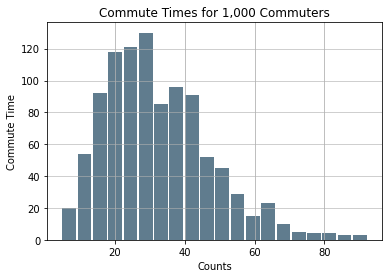

In [7]:
import pandas as pd

# Generate data on commute times.
size, scale = 1000, 10
commutes = pd.Series(np.random.gamma(scale, size=size) ** 1.5)

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

[20, 15, 85, 20, 36]


([<matplotlib.axis.XTick at 0x22b0a98c198>,
 [Text(0, 0, 'casa'),
  Text(0, 0, 'gripe'),
  Text(0, 0, 'neomia'),
  Text(0, 0, 'muerte'),
  Text(0, 0, 'sala')])

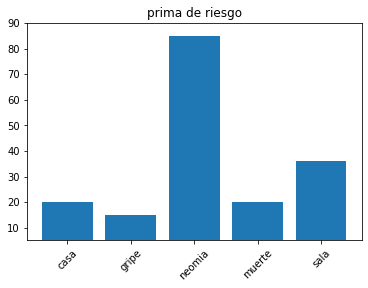

In [39]:

import datetime as dt  # Importamos el módulo datetime
prima = [20, 15, 85, 20 ,36]  # Valores inventados para la prima de riesgo
print(prima)
fechas = {'neomia','muerte','sala','gripe','casa'} # generamos las fechas de los últimos cinco días
#plt.axes((0.1, 0.3, 0.8, 0.6))  # Definimos la posición de los ejes
plt.bar(np.arange(5), prima)  # Dibujamos el gráfico de barras
plt.ylim(5,90)  # Limitamos los valores del eje y al range definido [450, 550]
plt.title('prima de riesgo')  # Colocamos el título
plt.xticks(np.arange(5), fechas, rotation = 45) 

In [43]:
import pandas as pd
clients = {'Tipos' : ['Ninios' ,'Adultos' ,'Mayores', 'Mas Mayores', 'Super Mayores'],
           'last_name' : ['Fidgeon' ,'Benet' ,'Woodlands', 'Risdale', 'MacGorman'],
           'age' : [30 ,21 ,29 ,22, 24]}
clients = pd.DataFrame(clients, columns = ['Tipos', 'last_name', 'age'])
clients

,Tipos,last_name,age
0,Ninios,Fidgeon,30
1,Adultos,Benet,21
2,Mayores,Woodlands,29
3,Mas Mayores,Risdale,22
4,Super Mayores,MacGorman,24
